# Pipeline Performance Analysis


### Load necessary libraries and inputs

In [ ]:
# install.packages("ggExtra")
# install.packages("lubridate")
# install.packages("patchwork")
# install.packages("tidyr")

Installing package into ‘/home/bia/R/x86_64-pc-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



In [1]:
library(ggplot2)     # For creating plots
library(dplyr)       # For data manipulation
library(tidyr)       # For reshaping data
library(ggExtra)     # For adding marginal histograms
library(lubridate)   # For date manipulation
library(patchwork)   # For combining plots
library(stringr)     # For string manipulation


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




## General Data Preprocessing and Cleaning

In [2]:
# Read the trace data from a tab-delimited file
trace_data <- read.delim("trace84443.txt", sep = "\t",
                         header = TRUE, stringsAsFactors = FALSE)
head(trace_data)

# Filter the data to include only completed processes
trace_data_processed <- trace_data %>% filter(status == "COMPLETED")

# Separate the 'name' column into 'process' and 'id'
trace_data_processed <- trace_data_processed %>%
  separate(name, into = c("process", "id"),
           sep = " \\(", extra = "merge", remove = FALSE) %>%
  mutate(id = gsub("\\)", "", id))

head(trace_data_processed)

,task_id,hash,native_id,name,status,exit,submit,duration,realtime,X.cpu,peak_rss,peak_vmem,rchar,wchar
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,6,a5/073da2,84445,getReadFTP (5),COMPLETED,0,2025-05-01 11:44:04.419,18.5s,8.4s,9.1%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
2,3,4c/7dc12c,84446,getReadFTP (2),COMPLETED,0,2025-05-01 11:44:04.663,18.5s,8.4s,8.7%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
3,5,89/cacdb9,84444,getReadFTP (4),COMPLETED,0,2025-05-01 11:44:04.121,23.8s,8.7s,8.2%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
4,2,09/ea6cc7,84449,getReadFTP (1),COMPLETED,0,2025-05-01 11:44:23.401,14.6s,6.3s,7.1%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
5,4,71/e27766,84448,getReadFTP (3),COMPLETED,0,2025-05-01 11:44:23.163,51.3s,23.1s,2.1%,25.2 MB,343.4 MB,3.8 MB,3.5 KB
6,1,c3/306c0e,84447,genomeGenerateSTAR,COMPLETED,0,2025-05-01 11:44:04.889,3m 19s,3m 8s,108.2%,3 GB,5 GB,2.2 GB,4.4 GB


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 1 rows [6].”


,task_id,hash,native_id,name,process,id,status,exit,submit,duration,realtime,X.cpu,peak_rss,peak_vmem,rchar,wchar
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04.419,18.5s,8.4s,9.1%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
2,3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04.663,18.5s,8.4s,8.7%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
3,5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04.121,23.8s,8.7s,8.2%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
4,2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23.401,14.6s,6.3s,7.1%,25.2 MB,342.2 MB,3.8 MB,3.5 KB
5,4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23.163,51.3s,23.1s,2.1%,25.2 MB,343.4 MB,3.8 MB,3.5 KB
6,1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04.889,3m 19s,3m 8s,108.2%,3 GB,5 GB,2.2 GB,4.4 GB


## Resource Consumption Over Time

#### Data processing

In [3]:
library(stringr)
library(dplyr)

# Convert the duration to seconds function
convert_to_seconds <- function(time_str) {
  time_str <- gsub("h", "H", time_str)
  time_str <- gsub("m", "M", time_str)
  time_str <- gsub("s", "S", time_str)
  duration <- lubridate::as.duration(time_str)
  seconds <- as.numeric(duration, "seconds")

  seconds
}

# Remove the "%" sign and convert to numeric
convert_cpu <- function(cpu) {
  cpu_value <- as.numeric(str_remove(cpu, "%"))

  cpu_value
}

# Function to convert memory string to numeric value in MB
clean_memory_column <- function(column) {
  value <- as.numeric(gsub("[^0-9.]", "", column)) # nolint
  unit <- gsub("[0-9. ]", "", column) # nolint

  value_mb <- case_when(
    unit == "KB" ~ value / 1024,  # Convert KB to MB
    unit == "MB" ~ value,         # Keep MB as is
    unit == "GB" ~ value * 1024,  # Convert GB to MB
    TRUE ~ NA_real_               # Handle unexpected units
  )

  value_mb
}

trace_data_processed <- trace_data_processed %>%
  mutate(submit = ymd_hms(submit),  # Convert 'submit' to datetime
         duration_sec = convert_to_seconds(duration), # Convert to seconds
         end_time = submit + seconds(duration_sec),  # Calculate end time
         cpu_percent = convert_cpu(X.cpu),   # Convert %cpu to numeric
         peak_rss_mb = clean_memory_column(peak_rss))  # Convert memory to MB

# Create a sequence of minutes
duration_by_minute <- seq(from = min(trace_data_processed$submit),
                    to = max(trace_data_processed$end_time),
                    by = "1 min")

# Calculate total CPU and memory usage for each minute
resources_by_minute <- data.frame(full_time = duration_by_minute) %>%
  rowwise() %>%
  mutate(
    cpu_total = sum(
      trace_data_processed$cpu_percent[trace_data_processed$submit
      <= full_time & trace_data_processed$end_time >= full_time], # nolint
      na.rm = TRUE
    ),
    mem_total = sum(
      trace_data_processed$peak_rss_mb[trace_data_processed$submit
      <= full_time & trace_data_processed$end_time >= full_time], # nolint
      na.rm = TRUE
    )
  )
# Create a minute index column
resources_by_minute$minute <- seq(0, nrow(resources_by_minute) - 1)

head(resources_by_minute)


full_time,cpu_total,mem_total,minute
<dttm>,<dbl>,<dbl>,<int>
2025-05-01 11:44:04,8.2,25.2,0
2025-05-01 11:45:04,121.8,3133.2,1
2025-05-01 11:46:04,126.7,3132.0,2
2025-05-01 11:47:04,126.7,3132.0,3
2025-05-01 11:48:04,18.5,60.0,4
2025-05-01 11:49:04,18.5,60.0,5


### Plot generation: CPU and Memory consumption over time

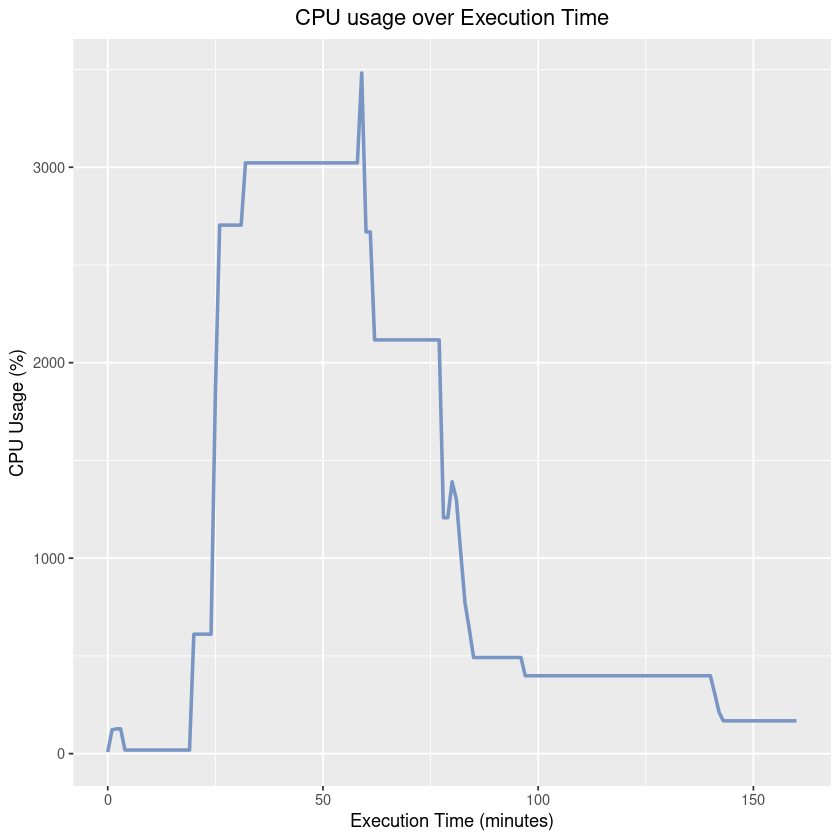

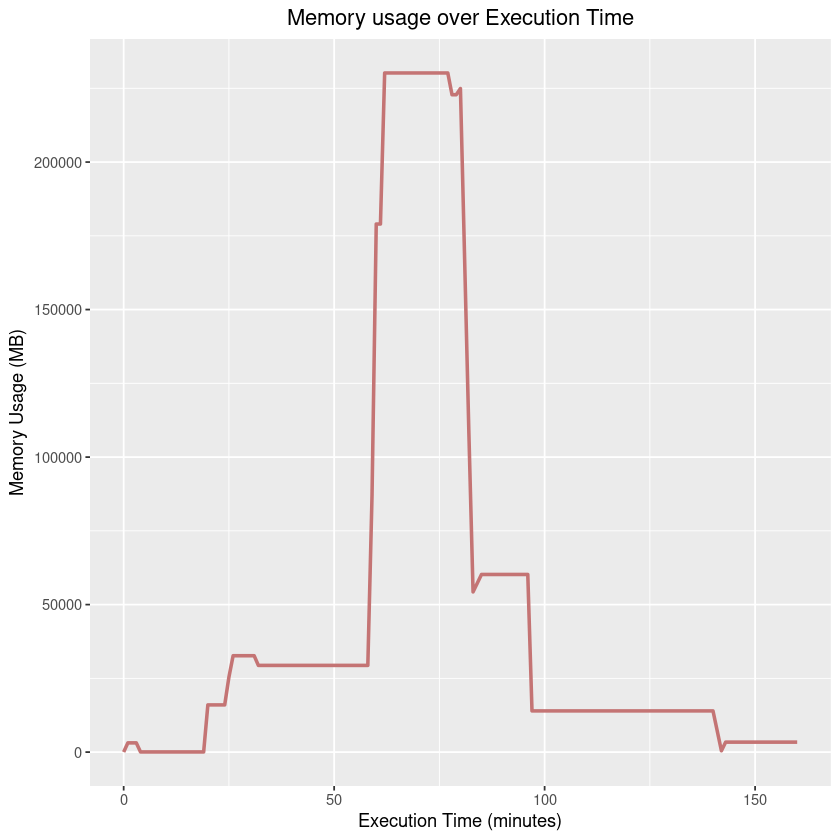

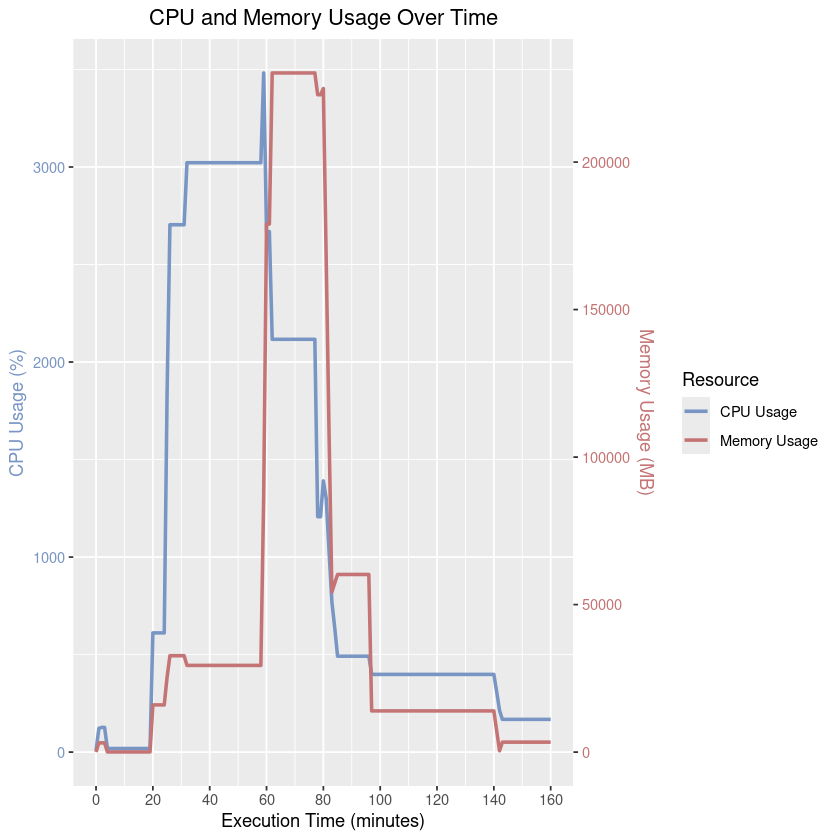

In [4]:
# CPU % Usage over time
cpu_over_time <- ggplot(resources_by_minute, aes(x = minute, y = cpu_total)) +
  geom_line(color = "#7895c4", linewidth = 1) +
  labs(
    title = "CPU usage over Execution Time",
    x = "Execution Time (minutes)",
    y = "CPU Usage (%)"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) 

cpu_over_time

# Memory MB Usage over time
mem_over_time <- ggplot(resources_by_minute, aes(x = minute, y = mem_total)) +
  geom_line(color = "#c47474", linewidth = 1) +
  labs(
    title = "Memory usage over Execution Time",
    x = "Execution Time (minutes)",
    y = "Memory Usage (MB)"
  ) +
  theme_gray() +
  theme(plot.title = element_text(hjust = 0.5)) 

mem_over_time

scaling_factor <- max(resources_by_minute$mem_total) /
  max(resources_by_minute$cpu_total)


# Resource Usage Over Time
resources_over_time <- ggplot(resources_by_minute) +
  geom_line(
    aes(x = minute, y = cpu_total, color = "CPU Usage"),
    linewidth = 1
  ) +
  geom_line(
    aes(x = minute, y = mem_total / scaling_factor, color = "Memory Usage"),
    linewidth = 1
  ) +
  # Dual y-axes
  scale_y_continuous(
    name = "CPU Usage (%)",
    sec.axis = sec_axis(
      ~ . * scaling_factor,  
      name = "Memory Usage (MB)"
    )
  ) +
  scale_x_continuous(
    name = "Execution Time (minutes)", 
    breaks = seq(0, max(resources_by_minute$minute), by = 20)
  ) +
  scale_color_manual(
    values = c("CPU Usage" = "#7895c4", "Memory Usage" = "#c47474")
  ) +
  labs(
    color = "Resource",
    title = "CPU and Memory Usage Over Time"
  ) +
  theme_gray() +
  theme(
        legend.position = "right",
        axis.title.y.right = element_text(color = "#c47474"),
        axis.text.y.right = element_text(color = "#c47474"),
        axis.title.y.left = element_text(color = "#7895c4"),
        axis.text.y.left = element_text(color = "#7895c4"),
        plot.title = element_text(hjust = 0.5))

print(resources_over_time)


## Resources and Parallelism Analysis 

#### Data processing

In [5]:
# Calculate the start and end times in minutes from the minimum submit time
trace_data_processed <- trace_data_processed %>%
  mutate(
    start_minutes = as.numeric(difftime(submit, min(submit), units = "mins")),
    end_minutes = as.numeric(difftime(end_time, min(submit), units = "mins"))
  )

head(trace_data_processed)

,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,peak_rss,peak_vmem,rchar,wchar,duration_sec,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,25.2 MB,342.2 MB,3.8 MB,3.5 KB,18.5,2025-05-01 11:44:22,9.1,25.2,0.004966668,0.3133000
2,3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,25.2 MB,342.2 MB,3.8 MB,3.5 KB,18.5,2025-05-01 11:44:23,8.7,25.2,0.009033334,0.3173667
3,5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04,23.8s,⋯,25.2 MB,342.2 MB,3.8 MB,3.5 KB,23.8,2025-05-01 11:44:27,8.2,25.2,0.000000000,0.3966667
4,2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,14.6s,⋯,25.2 MB,342.2 MB,3.8 MB,3.5 KB,14.6,2025-05-01 11:44:38,7.1,25.2,0.321333333,0.5646667
5,4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23,51.3s,⋯,25.2 MB,343.4 MB,3.8 MB,3.5 KB,51.3,2025-05-01 11:45:14,2.1,25.2,0.317366668,1.1723667
6,1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04,3m 19s,⋯,3 GB,5 GB,2.2 GB,4.4 GB,199.0,2025-05-01 11:47:23,108.2,3072.0,0.012799998,3.3294667


### Plot Generation: Parallelism and Resource Consumption

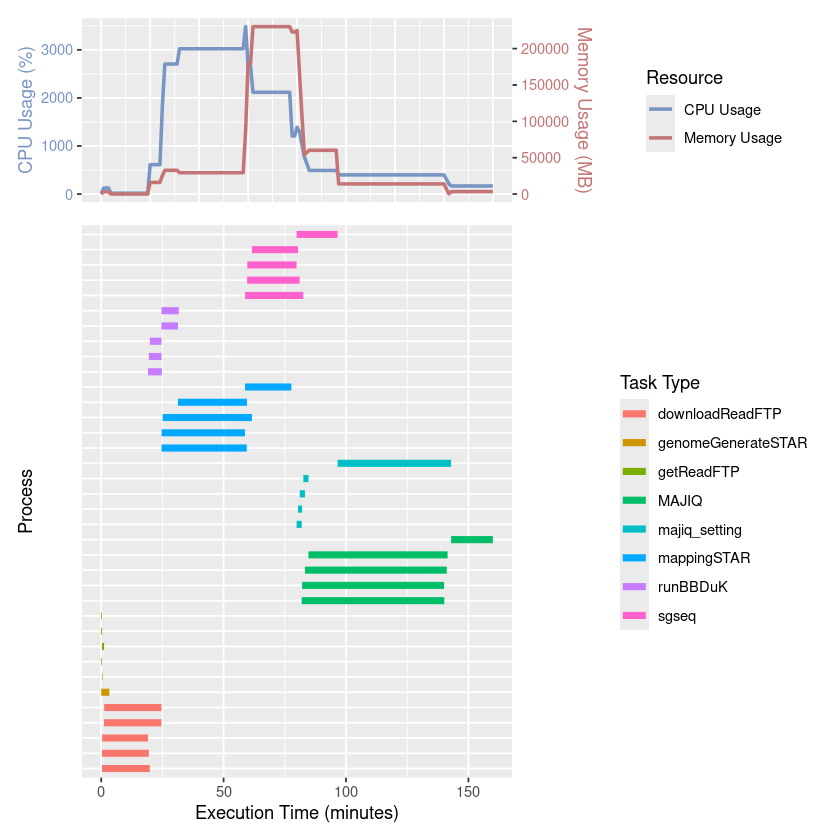

In [6]:
# Edit the CPU and Memory usage plot to remove title and x-axis elements
cpu_mem_edit <- resources_over_time +
  theme(
    plot.title = element_blank(),
    axis.text.x = element_blank(),
    axis.title.x = element_blank(),
    axis.ticks.x = element_blank()
  )

# Create a Gantt chart to visualize the process execution times
gantt_plot <- ggplot(trace_data_processed) +
  geom_segment(
    aes(
      x = start_minutes,
      xend = end_minutes,
      y = name,
      yend = name,
      color = process
    ),
    linewidth = 2
  ) +
  labs(
    x = "Execution Time (minutes)",
    y = "Process",
    color = "Task Type"
  ) +
  theme_gray() +
  theme(
    legend.position = "right",
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()
  )

# Combine the edited CPU/Memory plot and the Gantt chart
final_plot <- cpu_mem_edit / gantt_plot +
  plot_layout(heights = c(1, 3))

final_plot

## Summary resources usage by Nextflow process 

#### Data processing

In [8]:
convert_to_minutes <- function(time_str) {
  time_str <- gsub("h", "H", time_str)
  time_str <- gsub("m", "M", time_str)
  time_str <- gsub("s", "S", time_str)

  duration <- lubridate::as.duration(time_str)
  minutes <- as.numeric(duration, "minutes")

  minutes
}

trace_data_processed <- trace_data_processed %>%
  mutate(duration_min = convert_to_minutes(duration))

head(trace_data_processed)

,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,peak_vmem,rchar,wchar,duration_sec,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes,duration_min
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,342.2 MB,3.8 MB,3.5 KB,18.5,2025-05-01 11:44:22,9.1,25.2,0.004966668,0.3133000,0.3083333
2,3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,342.2 MB,3.8 MB,3.5 KB,18.5,2025-05-01 11:44:23,8.7,25.2,0.009033334,0.3173667,0.3083333
3,5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04,23.8s,⋯,342.2 MB,3.8 MB,3.5 KB,23.8,2025-05-01 11:44:27,8.2,25.2,0.000000000,0.3966667,0.3966667
4,2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,14.6s,⋯,342.2 MB,3.8 MB,3.5 KB,14.6,2025-05-01 11:44:38,7.1,25.2,0.321333333,0.5646667,0.2433333
5,4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23,51.3s,⋯,343.4 MB,3.8 MB,3.5 KB,51.3,2025-05-01 11:45:14,2.1,25.2,0.317366668,1.1723667,0.8550000
6,1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04,3m 19s,⋯,5 GB,2.2 GB,4.4 GB,199.0,2025-05-01 11:47:23,108.2,3072.0,0.012799998,3.3294667,3.3166667


### Plot generation: Scatter plot of resources usage by Nextflow process

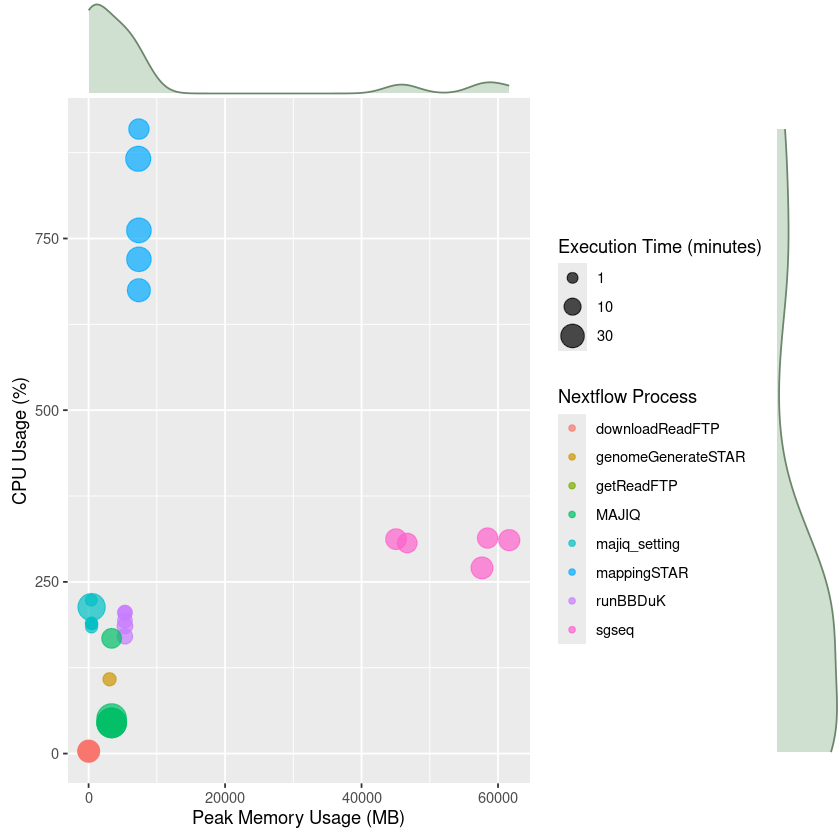

In [9]:
resources_plot <- ggplot(trace_data_processed,
                         aes(x = peak_rss_mb, y = cpu_percent)) +
  geom_point(
    aes(
      color = process,
      size = duration_min
    ),
    alpha = 0.7
  ) +
  scale_size_continuous(
    range = c(2, 8),
    breaks = c(1, 10, 30, 60, 120, 240),
    name = "Execution Time (minutes)"
  ) +
  labs(
    x = "Peak Memory Usage (MB)",
    y = "CPU Usage (%)",
    color = "Nextflow Process"
  ) +
  theme_gray() +
  theme(legend.position = "right")

summary_resource_plot <- ggMarginal(
  resources_plot,
  type = "density",
  margins = "both",
  fill = "#bcd3bc",
  col = "#6b866b",
  alpha = 0.7,
  size = 7
)

print(summary_resource_plot)

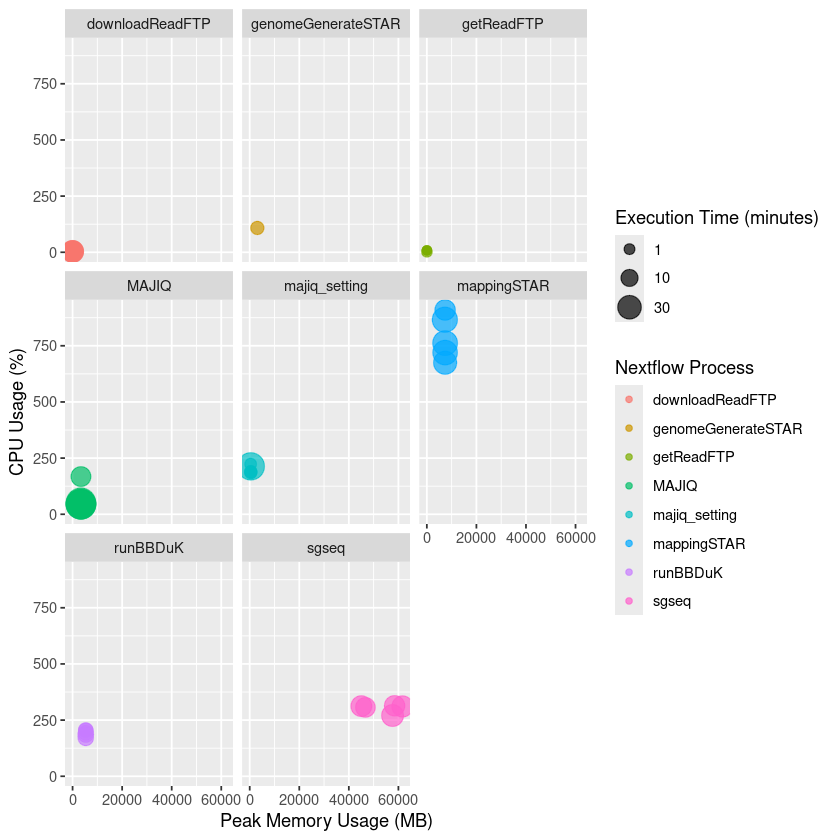

In [10]:
resources_plot +
  facet_wrap(~ process)

In [11]:
trace_data_processed$index <- as.integer(sub(".*\\((\\d+)\\).*", "\\1", trace_data_processed$name))

srr_list <- readLines("TEST_5SRR_list.txt")
trace_data_processed$srr <- srr_list[trace_data_processed$index]
head(trace_data_processed)

Warning message:
“NAs introduced by coercion”


,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,wchar,duration_sec,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes,duration_min,index,srr
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,3.5 KB,18.5,2025-05-01 11:44:22,9.1,25.2,0.004966668,0.3133000,0.3083333,5,SRR24283874
2,3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,3.5 KB,18.5,2025-05-01 11:44:23,8.7,25.2,0.009033334,0.3173667,0.3083333,2,SRR28672143
3,5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04,23.8s,⋯,3.5 KB,23.8,2025-05-01 11:44:27,8.2,25.2,0.000000000,0.3966667,0.3966667,4,SRR11684912
4,2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,14.6s,⋯,3.5 KB,14.6,2025-05-01 11:44:38,7.1,25.2,0.321333333,0.5646667,0.2433333,1,SRR22225469
5,4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23,51.3s,⋯,3.5 KB,51.3,2025-05-01 11:45:14,2.1,25.2,0.317366668,1.1723667,0.8550000,3,SRR28872355
6,1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04,3m 19s,⋯,4.4 GB,199.0,2025-05-01 11:47:23,108.2,3072.0,0.012799998,3.3294667,3.3166667,NA,NA


In [12]:
library(DBI)
library(RSQLite)

con <- dbConnect(SQLite(), "~/grasses.db")

get_num_spots <- function(srr) {
  query <- sprintf("SELECT number_of_spots FROM sra_metadata WHERE sra_id = '%s'", srr)
  res <- dbGetQuery(con, query)
  if (nrow(res) == 0) return(NA)
  return(res$number_of_spots[1])
}

trace_data_processed$number_of_spots <- sapply(trace_data_processed$srr, get_num_spots)
trace_data_processed$number_of_reads <- 2 * as.numeric(trace_data_processed$number_of_spots)
head(trace_data_processed)

,task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,end_time,cpu_percent,peak_rss_mb,start_minutes,end_minutes,duration_min,index,srr,number_of_spots,number_of_reads
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>
1,6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,2025-05-01 11:44:22,9.1,25.2,0.004966668,0.3133000,0.3083333,5,SRR24283874,21665753,43331506
2,3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,2025-05-01 11:44:23,8.7,25.2,0.009033334,0.3173667,0.3083333,2,SRR28672143,21743742,43487484
3,5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04,23.8s,⋯,2025-05-01 11:44:27,8.2,25.2,0.000000000,0.3966667,0.3966667,4,SRR11684912,22647709,45295418
4,2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,14.6s,⋯,2025-05-01 11:44:38,7.1,25.2,0.321333333,0.5646667,0.2433333,1,SRR22225469,20401273,40802546
5,4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23,51.3s,⋯,2025-05-01 11:45:14,2.1,25.2,0.317366668,1.1723667,0.8550000,3,SRR28872355,22535151,45070302
6,1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04,3m 19s,⋯,2025-05-01 11:47:23,108.2,3072.0,0.012799998,3.3294667,3.3166667,NA,NA,NA,NA


In [13]:
valid_reads <- trace_data_processed$number_of_reads[!is.na(trace_data_processed$number_of_reads)]

quartiles <- quantile(valid_reads, probs = c(0, 0.25, 0.5, 0.75, 1))
quartile_labels <- paste(
  formatC(quartiles[-length(quartiles)], format = "d", big.mark = ","),
  "-",
  formatC(quartiles[-1], format = "d", big.mark = ",")
)

# add quartile value labels and "all SRR" label for NA
trace_data_processed$reads_quartile <- cut(trace_data_processed$number_of_reads,
                                           breaks = quartiles,
                                           include.lowest = TRUE,
                                           labels = quartile_labels)
trace_data_processed$reads_quartile <- as.character(trace_data_processed$reads_quartile)
trace_data_processed$reads_quartile[is.na(trace_data_processed$reads_quartile)] <- "all SRR"
trace_data_processed$reads_quartile <- factor(trace_data_processed$reads_quartile,
                                              levels = c(quartile_labels, "all SRR"))

trace_data_processed

task_id,hash,native_id,name,process,id,status,exit,submit,duration,⋯,cpu_percent,peak_rss_mb,start_minutes,end_minutes,duration_min,index,srr,number_of_spots,number_of_reads,reads_quartile
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dttm>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<fct>
6,a5/073da2,84445,getReadFTP (5),getReadFTP,5,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,9.1,25.2,4.966668e-03,0.3133000,0.3083333,5,SRR24283874,21665753,43331506,"40,802,546 - 43,331,506"
3,4c/7dc12c,84446,getReadFTP (2),getReadFTP,2,COMPLETED,0,2025-05-01 11:44:04,18.5s,⋯,8.7,25.2,9.033334e-03,0.3173667,0.3083333,2,SRR28672143,21743742,43487484,"43,331,506 - 43,487,484"
5,89/cacdb9,84444,getReadFTP (4),getReadFTP,4,COMPLETED,0,2025-05-01 11:44:04,23.8s,⋯,8.2,25.2,0.000000e+00,0.3966667,0.3966667,4,SRR11684912,22647709,45295418,"45,070,302 - 45,295,418"
2,09/ea6cc7,84449,getReadFTP (1),getReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,14.6s,⋯,7.1,25.2,3.213333e-01,0.5646667,0.2433333,1,SRR22225469,20401273,40802546,"40,802,546 - 43,331,506"
4,71/e27766,84448,getReadFTP (3),getReadFTP,3,COMPLETED,0,2025-05-01 11:44:23,51.3s,⋯,2.1,25.2,3.173667e-01,1.1723667,0.8550000,3,SRR28872355,22535151,45070302,"43,487,484 - 45,070,302"
1,c3/306c0e,84447,genomeGenerateSTAR,genomeGenerateSTAR,NA,COMPLETED,0,2025-05-01 11:44:04,3m 19s,⋯,108.2,3072.0,1.280000e-02,3.3294667,3.3166667,NA,NA,NA,NA,all SRR
9,00/acd36f,84452,downloadReadFTP (3),downloadReadFTP,3,COMPLETED,0,2025-05-01 11:44:28,18m 42s,⋯,4.2,12.0,4.005667e-01,19.1005667,18.7000000,3,SRR28872355,22535151,45070302,"43,487,484 - 45,070,302"
8,5e/d8a6fd,84450,downloadReadFTP (2),downloadReadFTP,2,COMPLETED,0,2025-05-01 11:44:23,19m 8s,⋯,4.0,12.0,3.245667e-01,19.4579000,19.1333333,2,SRR28672143,21743742,43487484,"43,331,506 - 43,487,484"
7,60/59a654,84451,downloadReadFTP (1),downloadReadFTP,1,COMPLETED,0,2025-05-01 11:44:23,19m 32s,⋯,3.3,12.0,3.277833e-01,19.8611167,19.5333333,1,SRR22225469,20401273,40802546,"40,802,546 - 43,331,506"


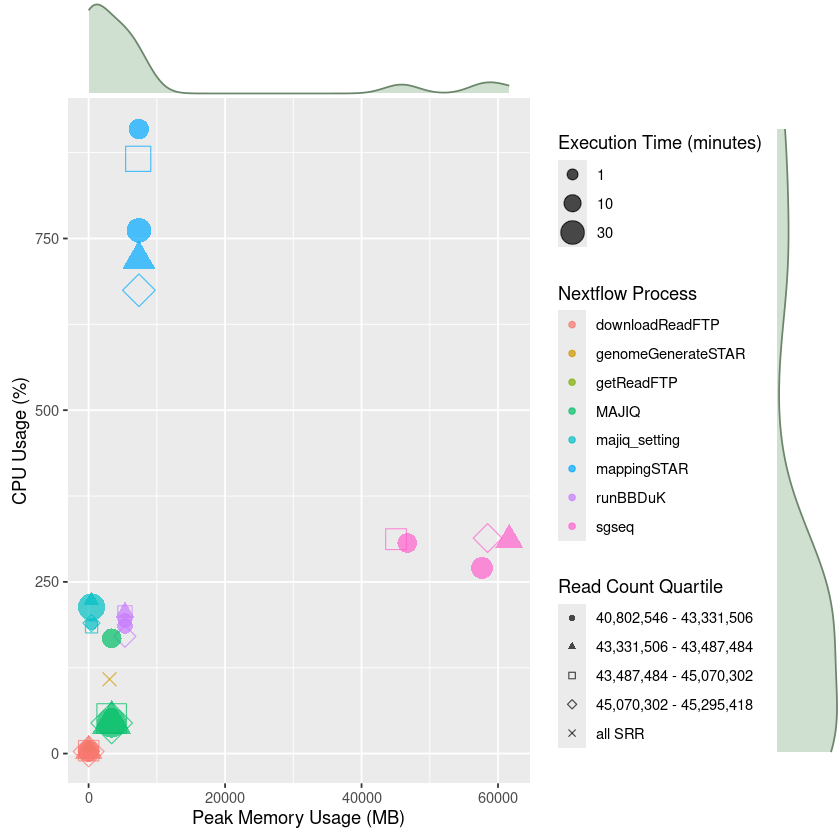

In [14]:
resources_plot <- ggplot(trace_data_processed,
                         aes(x = peak_rss_mb, y = cpu_percent)) +
  geom_point(
    aes(
      color = process,
      size = duration_min,
      shape = reads_quartile
    ),
    alpha = 0.7
  ) +
  scale_size_continuous(
    range = c(2, 8),
    breaks = c(1, 10, 30, 60, 120, 240),
    name = "Execution Time (minutes)"
  ) +
  scale_shape_manual(
    values = c(16, 17, 0, 5, 4), # here is where I can define the shapes
    name = "Read Count Quartile"
  ) +
  labs(
    x = "Peak Memory Usage (MB)",
    y = "CPU Usage (%)",
    color = "Nextflow Process"
  ) +
  theme_gray() +
  theme(legend.position = "right")

summary_resource_plot <- ggMarginal(
  resources_plot,
  type = "density",
  margins = "both",
  fill = "#bcd3bc",
  col = "#6b866b",
  alpha = 0.7,
  size = 7
)

print(summary_resource_plot)
